<a href="https://colab.research.google.com/github/jorgeerrz/mistaken_mice/blob/master/mistaken_mice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mistaken Mice notebook

2020 NMA academy project, mistaken mice group, pod 173 antique cicada

# Import packages and functions

In [1]:
# to import the functions we wrote, clone the git repo
# !git clone https://github.com/jorgeerrz/mistaken_mice.git
# %cd mistaken_mice
#alternatively, run the notebook locally, then just comment the lines above

# from filter import *
# from summarise_dataset import *
# from PCA_fun import neurons_PCA
# from GLM import *

%load_ext autoreload
%autoreload 2

In [38]:
from filter import *
from summarise_dataset import *
from PCA_fun import neurons_PCA
from GLM import *
from rebin import *
from model_tester import test_model

# Loading of Steinmetz data

In [3]:
#@title Data retrieval
import os, requests

fname = []
for j in range(3):
  fname.append('steinmetz_part%d.npz'%j)


In [4]:
# skip if you already downloaded the data
url = ["https://osf.io/agvxh/download"]
url.append("https://osf.io/uv3mw/download")
url.append("https://osf.io/ehmw2/download")

for j in range(len(url)):
  if not os.path.isfile(fname[j]):
    try:
      r = requests.get(url[j])
    except requests.ConnectionError:
      print("!!! Failed to download data !!!")
    else:
      if r.status_code != requests.codes.ok:
        print("!!! Failed to download data !!!")
      else:
        with open(fname[j], "wb") as fid:
          fid.write(r.content)

In [5]:
#@title Data loading
import numpy as np

alldat = np.array([])
for j in range(len(fname)):
  alldat = np.hstack((alldat, np.load('steinmetz_part%d.npz'%j, allow_pickle=True)['dat']))


# Change the time bin
Optional step

In [6]:
dat = first_session_filtered
NT = dat['spks'].shape[-1]
minT = 50
maxT = 130
NN = dat['spks'].shape[0]

droll = np.reshape(dat['spks'][:,:,minT:maxT], (NN,-1))

dat['spks'][:,:,minT:maxT].mean(axis=2).shape


NameError: name 'first_session_filtered' is not defined

# Filter, PCA, and Model one session

In [ ]:
filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
rebinned = rebin(filtered, 50, 250, 2)
rebinned['spks'].shape, filtered['spks'].shape

In [ ]:
probs[:,1]

In [ ]:
from sklearn.model_selection import *

session = 0
brain_areas = ["MOs"]


filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
#filtered = rebin(filtered, 50, 250, 2)
dat = neurons_PCA(filtered,0.9,50,250,toplot=False)
#dat['PCs'] = dat['PCs'][0:dat['PCrange'],:]

lambda_L2 = 1
penalty = "l2"
l1args = {}
left_bias = np.mean((filtered['chcs'])==1)
choice_bias = [left_bias if left_bias > .5 else (1.0-left_bias)]
w = {-1:left_bias, 1:(1-left_bias)}



logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args,class_weight=w).fit(dat['PCs'].T, filtered['chcs'])
splitter = LeaveOneOut()
splits = splitter.split(dat['PCs'].T)
accuracies=[]
predictions = []
probs = []
#Manual K-1 corss validation, saving predicitons:
for fit_trials,test_trial in splits:
    logreg.fit((dat['PCs'][:,fit_trials]).T, dat['chcs'][fit_trials])
    prediction = logreg.predict(dat['PCs'][:,test_trial].T)[0]
    prob = logreg.predict_proba(dat['PCs'][:,test_trial].T)[0]
    actual = dat['chcs'][test_trial][0]
    accuracy = int(actual == prediction)
    predictions.append(prediction)
    accuracies.append(accuracy)
    probs.append(prob)

probs = np.array(probs)
mprobs = [max(prob) for prob in probs]

print('Number of PCs: '+str(dat['PCrange']))

print('Accuracies: '+str(accuracies))
print('Mean Accuracy: '+str(np.mean(accuracies)))
print('Predictions: '+ str(predictions))
print('Actual: '+ str(filtered['chcs']))
print('Probs: '+ str(probs))
actual_choice_probs = [(prob[0] if choice==-1 else prob[1]) for prob,choice in zip(probs,filtered['chcs'])]
print('Brier score: '+str(np.sum((probs[:,1] - (filtered['chcs'] + 1)/2)**2)))
print('Weight right: '+str(w[-1])+' weight left: '+str(w[1]))
print('Percent Left: ' +str(np.mean((filtered['chcs'])==1)))
print('Percent Right: ' +str(np.mean((filtered['chcs'])==-1)))

plt.plot(predictions,linewidth=0,marker='o')
plt.plot(filtered['chcs'],linewidth=0,marker='x')



# one session, get PCA and model weights together

In [ ]:
plot_session(alldat,session,unfair_only=True,chosey_only=True, nonzero_only=True, select_areas = allb)

In [ ]:
# help(LogisticRegression)

(12, 753)
(1, 12)


,Neuron,Coef,Brain Area
545,545,-0.424224,MRN
552,552,-0.364897,MRN
549,549,-0.320633,MRN
551,551,-0.247662,MRN
454,454,-0.161707,MRN
...,...,...,...
529,529,0.171833,MRN
541,541,0.178847,MRN
431,431,0.200080,MRN
542,542,0.253204,MRN


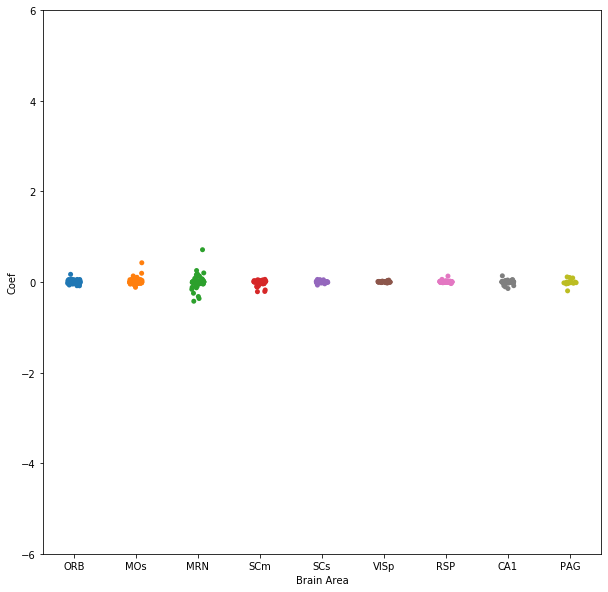

In [88]:
import pandas as pd
import seaborn as sns

allb = ['ACA','ACB','APN', 'AUD', 'BLA', 'BMA', 'CA', 'CA1', 'CA2', 'CA3', 'CL', 'COA',
 'CP','DG','DP','EP','EPd','GPe','IC' ,'ILA', 'LD', 'LGd' ,'LH', 'LP', 'LS',
 'LSc','LSr','MB','MD','MEA','MG','MOp','MOs','MRN','MS','NB','OLF','ORB',
 'ORBm','OT','PAG','PIR','PL','PO','POL','POST','PT','RN','RSP','RT',
 'SCig','SCm','SCs','SCsg','SI','SNr','SPF','SSp','SSs','SUB','TH','TT',
 'VAL','VISa','VISam','VISl','VISp','VISpm','VISrl','VPL','VPM','ZI']

session = 13
filtered = filter_spikes(alldat,session,unfair_only=True,chosey_only=True, nonzero_only=True,brain_area=allb)
dat = neurons_PCA(filtered,0.9,0,250)
print(np.shape(dat['weights']))


lambda_L2 = 1
penalty = "l1"
l1args = {'max_iter':5000,'solver':'saga'}
left_bias = np.mean((filtered['chcs'])==1)
choice_bias = [left_bias if left_bias > .5 else (1.0-left_bias)]
w = {-1:left_bias, 1:(1-left_bias)}
# l1args = {'solver':"saga", 'max_iter':5000}
logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args)
logreg.fit((dat['PCs']).T, dat['chcs'])
print(np.shape(logreg.coef_))

pclogreg_coeffs = logreg.coef_ @ dat['weights']
#print(np.shape(pclogreg_coeffs))

#brain_coeffs = []
#for i,coef in enumerate(pclogreg_coeffs[0,:]):
#     plt.plot([i],[coef], 'o', label=filtered['brain_area'][i])

pclogreg_coeffs_f = pclogreg_coeffs[0,:]

data_summary = pd.DataFrame({'Neuron':np.arange(len(pclogreg_coeffs_f)),'Coef':pclogreg_coeffs_f,'Brain Area':filtered['brain_area']})        
# plt.plot(pclogreg_coeffs[0,:], 'o', label=filtered['brain_area'])


fig,axe = plt.subplots(1, 1, figsize=(10, 10))

sns.stripplot(x='Brain Area',y='Coef',data=data_summary,ax=axe)
axe.set_ylim(-6,6)
data_summary.groupby('Brain Area').agg(lambda x: np.sum((np.abs(x)>(np.std(x)+np.mean(x)))))
data_summary[data_summary['Brain Area']=='MRN'].sort_values('Coef')

# Filter, PCA, and Model all sessions (with neurons)

In [12]:
allb = ['ACA','ACB','APN', 'AUD', 'BLA', 'BMA', 'CA', 'CA1', 'CA2', 'CA3', 'CL', 'COA',
 'CP','DG','DP','EP','EPd','GPe','IC' ,'ILA', 'LD', 'LGd' ,'LH', 'LP', 'LS',
 'LSc','LSr','MB','MD','MEA','MG','MOp','MOs','MRN','MS','NB','OLF','ORB',
 'ORBm','OT','PAG','PIR','PL','PO','POL','POST','PT','RN','RSP','RT',
 'SCig','SCm','SCs','SCsg','SI','SNr','SPF','SSp','SSs','SUB','TH','TT',
 'VAL','VISa','VISam','VISl','VISp','VISpm','VISrl','VPL','VPM','ZI']

brain_areas = ['MOs']
brain_areas = allb

for session in range(len(alldat)):
    if np.sum(np.isin(alldat[session]['brain_area'],brain_areas))>0:
        filtered = filter_spikes(alldat,session,unfair_only=True,chosey_only=True, nonzero_only=True,brain_area=brain_areas)
        #filtered = rebin(filtered, 50, 250, 2)
        dat = neurons_PCA(filtered,0.9,0,250)
      # $ dat['PCs'] = dat['PCs'][0:dat['PCrange'],:]
        lambda_L2 = 1
        penalty = "none"
        l1args = {}
        left_bias = np.mean((filtered['chcs'])==1)
        choice_bias = [left_bias if left_bias > .5 else (1.0-left_bias)]
        w = {-1:left_bias, 1:(1-left_bias)}
       # l1args = {'solver':"saga", 'max_iter':5000}
        logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args)
        splitter = LeaveOneOut()
        splits = splitter.split(dat['PCs'].T)
        accuracies=[]
        predictions = []
        probs = []
        for fit_trials,test_trial in splits:
            logreg.fit((dat['PCs'][:,fit_trials]).T, dat['chcs'][fit_trials])
            prediction = logreg.predict(dat['PCs'][:,test_trial].T)[0]
            prob = logreg.predict_proba(dat['PCs'][:,test_trial].T)[0]
            actual = dat['chcs'][test_trial][0]
            accuracy = int(actual == prediction)
            predictions.append(prediction)
            accuracies.append(accuracy)
            probs.append(prob)   
        probs = np.array(probs)
        accuracies = np.array(accuracies)
        
        aob = accuracies.mean() - choice_bias
        print("Session# "+ str(session)+" accuracy = "+str(accuracies.mean())+" accuracy over bias = "+str(accuracies.mean() - choice_bias) + ", trial count= "+ str(len(accuracies)),"PC count= "+ str(dat['PCs'].shape[0]))

Session# 0 accuracy = 0.7 accuracy over bias = [-0.1], trial count= 10 PC count= 10
Session# 1 accuracy = 0.75 accuracy over bias = [0.2], trial count= 20 PC count= 20
Session# 2 accuracy = 0.7142857142857143 accuracy over bias = [0.0952381], trial count= 21 PC count= 21
Session# 3 accuracy = 0.5 accuracy over bias = [-0.2], trial count= 10 PC count= 10
Session# 4 accuracy = 0.8095238095238095 accuracy over bias = [0.04761905], trial count= 21 PC count= 21
Session# 5 accuracy = 0.47368421052631576 accuracy over bias = [-0.10526316], trial count= 19 PC count= 19
Session# 6 accuracy = 0.9166666666666666 accuracy over bias = [0.16666667], trial count= 12 PC count= 12
Session# 7 accuracy = 0.9166666666666666 accuracy over bias = [0.25], trial count= 12 PC count= 12
Session# 8 accuracy = 1.0 accuracy over bias = [0.33333333], trial count= 15 PC count= 15
Session# 9 accuracy = 0.7916666666666666 accuracy over bias = [0.16666667], trial count= 24 PC count= 24
Session# 10 accuracy = 0.91666666

ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0

# Filter, PCA, and Model w/ different time bins

In [ ]:
binl = 25
bins = [x for x in range(0,250,binl)]
brain_areas = ["MOp"]

for bin in bins:
    session = 10
    filtered = filter_spikes(alldat,session,unfair_only=True,brain_area=brain_areas)
    dat = neurons_PCA(filtered,0.9,bin,bin+binl)
    lambda_L2 = 1
    penalty = "l2"
    l1args = {}
    logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args).fit(dat['PCs'].T, filtered['chcs'])
    splitter = LeaveOneOut()
    splits = splitter.split(dat['PCs'].T)
    accuracies = cross_val_score(logreg,dat['PCs'].T, filtered['chcs'], cv=splits, verbose=0) # k=8 crossvalidation
    print("Bin "+str(bin)+" to "+str(bin+binl)+" accuracy mean= "+str(accuracies.mean())+ ", percent left "+ str(np.mean((filtered['chcs'])==-1)))

In [ ]:
[(session,np.sum(np.isin(alldat[session]['brain_area'],["VISam", "VISl", "VISp", "VISpm", "VISrl"])), np.sum(np.isin(alldat[session]['brain_area'],["ACB","CP"]))) for session in range(len(alldat))]

[(0, 178, 0),
 (1, 533, 0),
 (2, 228, 0),
 (3, 39, 0),
 (4, 0, 0),
 (5, 0, 0),
 (6, 0, 59),
 (7, 48, 0),
 (8, 142, 0),
 (9, 340, 0),
 (10, 0, 275),
 (11, 145, 0),
 (12, 34, 0),
 (13, 42, 0),
 (14, 0, 0),
 (15, 0, 0),
 (16, 0, 0),
 (17, 0, 313),
 (18, 179, 0),
 (19, 122, 0),
 (20, 0, 0),
 (21, 133, 92),
 (22, 190, 0),
 (23, 296, 0),
 (24, 94, 0),
 (25, 162, 0),
 (26, 103, 90),
 (27, 71, 0),
 (28, 0, 340),
 (29, 0, 0),
 (30, 0, 0),
 (31, 0, 0),
 (32, 0, 383),
 (33, 0, 0),
 (34, 75, 0),
 (35, 53, 0),
 (36, 77, 0),
 (37, 0, 0),
 (38, 141, 0)]

In [ ]:
aba = []
for session in alldat:
    for ba in session['brain_area']:
        if ba not in aba:
            aba.append(ba)
            
print(np.sort(aba))

['ACA' 'ACB' 'APN' 'AUD' 'BLA' 'BMA' 'CA' 'CA1' 'CA2' 'CA3' 'CL' 'COA'
 'CP' 'DG' 'DP' 'EP' 'EPd' 'GPe' 'IC' 'ILA' 'LD' 'LGd' 'LH' 'LP' 'LS'
 'LSc' 'LSr' 'MB' 'MD' 'MEA' 'MG' 'MOp' 'MOs' 'MRN' 'MS' 'NB' 'OLF' 'ORB'
 'ORBm' 'OT' 'PAG' 'PIR' 'PL' 'PO' 'POL' 'POST' 'PT' 'RN' 'RSP' 'RT'
 'SCig' 'SCm' 'SCs' 'SCsg' 'SI' 'SNr' 'SPF' 'SSp' 'SSs' 'SUB' 'TH' 'TT'
 'VAL' 'VISa' 'VISam' 'VISl' 'VISp' 'VISpm' 'VISrl' 'VPL' 'VPM' 'ZI'
 'root']


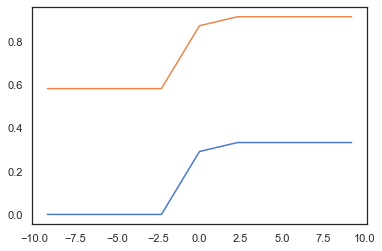

In [ ]:
lams = np.logspace(-4,4,num=9)
aobs = []
accs = []
for lam in lams:
    session = 10
    filtered = filter_spikes(alldat,session,unfair_only=True,chosey_only=True, nonzero_only=True,brain_area=brain_areas)
    dat = neurons_PCA(filtered,0.9,0,250)
    lambda_L2 = lam
    penalty = "l2"
    l1args = {}
    logreg = LogisticRegression(penalty = penalty, C = lambda_L2, **l1args).fit(dat['PCs'].T, filtered['chcs'])
    splitter = LeaveOneOut()
    splits = splitter.split(dat['PCs'].T)
    accuracies = cross_val_score(logreg,dat['PCs'].T, filtered['chcs'], cv=splits, verbose=0) # k=8 crossvalidation
    left_bias = np.mean((filtered['chcs'])==-1)
    choice_bias = [left_bias if left_bias > .5 else (1.0-left_bias)]
    aob = accuracies.mean() - choice_bias
    aobs.append(aob)
    accs.append(accuracies.mean())
plt.plot(np.log(lams),aobs)
plt.plot(np.log(lams),accs)

Session# 1 accuracy = 0.7 accuracy over bias = [0.15], trial count= 20 PC count= 13
Session# 2 accuracy = 0.42857142857142855 accuracy over bias = [-0.19047619], trial count= 21 PC count= 10
Session# 3 accuracy = 0.9 accuracy over bias = [0.2], trial count= 10 PC count= 5
Session# 4 accuracy = 0.8571428571428571 accuracy over bias = [0.0952381], trial count= 21 PC count= 10
Session# 7 accuracy = 0.5 accuracy over bias = [-0.16666667], trial count= 12 PC count= 5
Session# 8 accuracy = 0.6 accuracy over bias = [-0.06666667], trial count= 15 PC count= 7
Session# 9 accuracy = 0.5 accuracy over bias = [-0.125], trial count= 24 PC count= 11
Session# 11 accuracy = 0.8888888888888888 accuracy over bias = [0.27777778], trial count= 18 PC count= 8
Session# 12 accuracy = 0.9333333333333333 accuracy over bias = [0.13333333], trial count= 15 PC count= 6
Session# 18 accuracy = 0.75 accuracy over bias = [0.25], trial count= 16 PC count= 9
Session# 19 accuracy = 0.6129032258064516 accuracy over bias =

/Users/henryskelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/henryskelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/Users/henryskelton/opt/anaconda3/lib/python3.7/site-packages/sklearn/svm/_base.py:977: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


Session# 23 accuracy = 0.45454545454545453 accuracy over bias = [-0.36363636], trial count= 11 PC count= 6
Session# 26 accuracy = 0.7692307692307693 accuracy over bias = [0.07692308], trial count= 13 PC count= 6
Session# 27 accuracy = 1.0 accuracy over bias = [0.5], trial count= 4 PC count= 1
Session# 29 accuracy = 0.2857142857142857 accuracy over bias = [-0.28571429], trial count= 7 PC count= 2
Session# 34 accuracy = 0.631578947368421 accuracy over bias = [0.05263158], trial count= 19 PC count= 7
Session# 35 accuracy = 0.8421052631578947 accuracy over bias = [-0.05263158], trial count= 19 PC count= 7


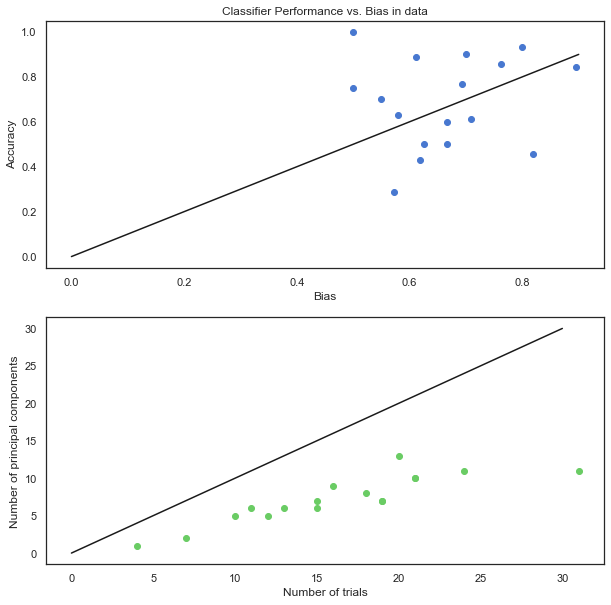

In [163]:
from model_tester import test_model
allb = ['ACA','ACB','APN', 'AUD', 'BLA', 'BMA', 'CA', 'CA1', 'CA2', 'CA3', 'CL', 'COA',
 'CP','DG','DP','EP','EPd','GPe','IC' ,'ILA', 'LD', 'LGd' ,'LH', 'LP', 'LS',
 'LSc','LSr','MB','MD','MEA','MG','MOp','MOs','MRN','MS','NB','OLF','ORB',
 'ORBm','OT','PAG','PIR','PL','PO','POL','POST','PT','RN','RSP','RT',
 'SCig','SCm','SCs','SCsg','SI','SNr','SPF','SSp','SSs','SUB','TH','TT',
 'VAL','VISa','VISam','VISl','VISp','VISpm','VISrl','VPL','VPM','ZI']


regions = ["vis ctx", "thal", "hipp", "other ctx", "midbrain", "basal ganglia", "cortical subplate", "other"]
brain_groups = [["VISa", "VISam", "VISl", "VISp", "VISpm", "VISrl"], # visual cortex
                ["CL", "LD", "LGd", "LH", "LP", "MD", "MG", "PO", "POL", "PT", "RT", "SPF", "TH", "VAL", "VPL", "VPM"], # thalamus
                ["CA", "CA1", "CA2", "CA3", "DG", "SUB", "POST"], # hippocampal
                ["ACA", "AUD", "COA", "DP", "ILA", "MOp", "MOs", "OLF", "ORB", "ORBm", "PIR", "PL", "SSp", "SSs", "RSP"," TT"], # non-visual cortex
                ["APN", "IC", "MB", "MRN", "NB", "PAG", "RN", "SCs", "SCm", "SCig", "SCsg", "ZI"], # midbrain
                ["ACB", "CP", "GPe", "LS", "LSc", "LSr", "MS", "OT", "SNr", "SI"], # basal ganglia 
                ["BLA", "BMA", "EP", "EPd", "MEA"] # cortical subplate
                ]



sessions = [*range(0,37)]
l2=1000000000000

output = test_model(alldat,sessions=sessions,brain_areas=["VISa", "VISam", "VISl", "VISpm", "VISrl"],unfair_only=True,chosey_only=True,nonzero_only=True,l2_penalty=l2,toweight=False,verbose=True)


plot_results(output)


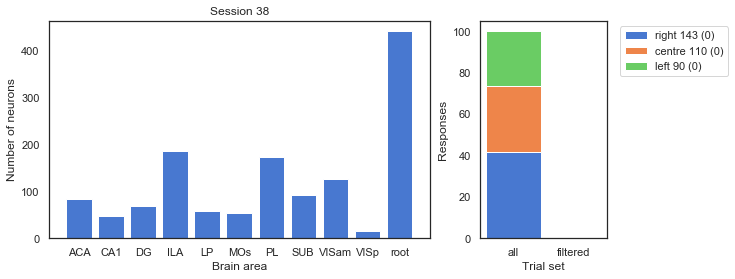

In [116]:
plot_session(alldat, 38, select_areas = None, unfair_only=True,chosey_only=True,nonzero_only=True)

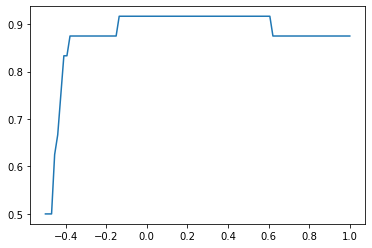

In [57]:
lambdas = np.logspace(-0.5,1,100)

outputs = [test_model(alldat,sessions=[],brain_areas=allb,unfair_only=True,chosey_only=True,nonzero_only=True,Cpen=x,penalty_type='l1',toweight=False,verbose=False) for x in lambdas]

testl2s = np.array([(lam,output['Accuracies'][0]) for lam,output in zip(lambdas,outputs)])
plt.plot(np.log10(testl2s[:,0]),testl2s[:,1])

In [49]:
testl2s

array([[1.00000000e-04, 5.41666667e-01],
       [7.74263683e-04, 3.75000000e-01],
       [5.99484250e-03, 5.41666667e-01],
       [4.64158883e-02, 6.25000000e-01],
       [3.59381366e-01, 6.66666667e-01],
       [2.78255940e+00, 9.16666667e-01],
       [2.15443469e+01, 8.75000000e-01],
       [1.66810054e+02, 9.16666667e-01],
       [1.29154967e+03, 9.16666667e-01],
       [1.00000000e+04, 9.16666667e-01]])

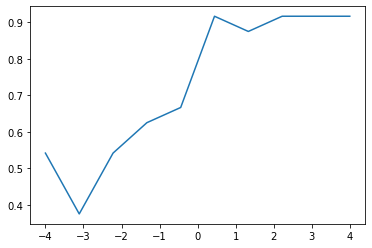